The code is based on what is available here: https://github.com/eriklindernoren/Keras-GAN/blob/master/cyclegan/cyclegan.py

Objective:
 - Try to build a CycleGAN that converts apples to oranges 🆒

In [3]:
# Get the apples2oranges dataset
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip -O apple2orange.zip
!unzip apple2orange.zip

for details.

--2019-07-28 02:36:36--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/apple2orange.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘apple2orange.zip’

apple2orange.zip    100%[===================>]  74.82M  55.5MB/s    in 1.3s    

2019-07-28 02:36:38 (55.5 MB/s) - ‘apple2orange.zip’ saved [78456409/78456409]

Archive:  apple2orange.zip
   creating: apple2orange/
   creating: apple2orange/trainA/
  inflating: apple2orange/trainA/n07740461_6908.jpg  
  inflating: apple2orange/trainA/n07740461_7635.jpg  
  inflating: apple2orange/trainA/n07740461_586.jpg  
  inflating: apple2orange/trainA/n07740461_9813.jpg  
  inflating: apple2orange/trainA/n07740461_6835.jpg  
  inflating: apple2orange/trainA/n07740461_2818.jpg  
  inflatin

In [6]:
!sudo pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-lxllh77h
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-lxllh77h
  Stored in directory: /tmp/pip-ephem-wheel-cache-_zyxpawb/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
from __future__ import division

import tensorflow as tf

import keras
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

import datetime
import numpy as np
from glob import glob
from PIL import Image

In [0]:
# Data Loader
class DataLoader:
  
  def __init__(self, datapath, img_res=(128, 128)):
    self.datapath = datapath
    self.img_res = img_res

  
  # load the entire dataset
  def load_batch(self, batch_size=1, is_testing=False):
    data_type = "train" if not is_testing else "test"
    path_A = glob('%s/%sA/*' % (self.datapath, data_type))
    path_B = glob('%s/%sB/*' % (self.datapath, data_type))
    
    self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
    total_samples = self.n_batches * batch_size
    
    path_A = np.random.choice(path_A, total_samples, replace=False)
    path_B = np.random.choice(path_B, total_samples, replace=False)
    
    for i in range(self.n_batches):
      batch_A = path_A[i*batch_size: (i+1)*batch_size]
      batch_B = path_B[i*batch_size: (i+1)*batch_size]
      
      imgs_A, imgs_B = [], []
      
      for imgA, imgB in zip(batch_A, batch_B):
        imgA = self.get_image(imgA)
        imgB = self.get_image(imgB)
       
        
        # Flip half the images horizontally in training set
        if not is_testing and np.random.random() > 0.5:
          imgA = np.fliplr(imgA)
          imgB = np.fliplr(imgB)
          
        imgs_A.append(imgA)
        imgs_B.append(imgB)
        
      yield (np.array(imgs_A), np.array(imgs_B))
        
        
  def get_image(self, path):
    image = Image.open('./' + path)
    image = image.resize(self.img_res)
    image = np.array(image)
    image = image / 127.5 - 1
    return image

In [0]:
class CycleGAN():
  
  def __init__(self, datapath):
    # Input shapes
    self.img_rows = 128
    self.img_cols = 128
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    
    # Configure the data loader
    self.data_loader = DataLoader(datapath=datapath)
    
    # The output shape of the discriminator (PatchGAN)
    # Discriminator has 4 conv layers with stride = 2.
    patch = int(self.img_rows / 2**4)
    self.disc_patch = (patch, patch, 1)
    
    # Number of filters in the first layer of Generator and Discriminator
    self.gf = 32
    self.df = 64
    
    # The weight each loss should get in the combined loss function
    self.lambda_valid = 1.0                   # Discriminator loss
    self.lambda_cycle = 10.0                  # Cycle-consistency loss 
    self.lambda_id = 0.1 * self.lambda_cycle  # Identity loss
    
    # Optimizer
    optimizer = Adam(0.0002, 0.5)
    
    # Build and compile the discriminators
    self.d_A = self.build_discriminator()    # Discriminator for domain A
    self.d_B = self.build_discriminator()    # Discriminator for domain B
    
    self.d_A.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
    self.d_B.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    # -------------------------------------    
    # Computational graph of the generators
    # -------------------------------------
    
    # Build the generators
    self.g_AB = self.build_generator()       # Generator for domain A -> B
    self.g_BA = self.build_generator()       # Generator for domain B -> A
    
    # Input images from both domains
    img_A = Input(shape=self.img_shape)
    img_B = Input(shape=self.img_shape)
    
    # Translate images to the other domain
    fake_B = self.g_AB(img_A)
    fake_A = self.g_BA(img_B)    
    
    # Translate images back to original domain
    reconstructed_A = self.g_BA(fake_B)
    reconstructed_B = self.g_AB(fake_A)
    
    # Identity mapping of the images
    img_id_A = self.g_BA(img_A)
    img_id_B = self.g_AB(img_B)
    
    # In the combined model, train only the generators
    self.d_A.trainable = False
    self.d_B.trainable = False
    
    # Use discriminators to check validity of images
    valid_A = self.d_A(fake_A)
    valid_B = self.d_B(fake_B)
    
    # Create combined model with discriminator and generator
    self.combined = Model(
      inputs  = [img_A, img_B],
      outputs = [valid_A, valid_B, reconstructed_A, reconstructed_B, img_id_A, img_id_B]
    )
    
    self.combined.compile(
        loss = ['mse', 'mse', 'mae', 'mae', 'mae', 'mae'],
        loss_weights = [
            self.lambda_valid, self.lambda_valid,
            self.lambda_cycle, self.lambda_cycle,
            self.lambda_id, self.lambda_id
        ],
        optimizer = optimizer
    )
    
    
    
  def build_discriminator(self):
    '''Build a discriminator network'''
    
    def d_layer(layer_input, filters, normalization=True):
      '''Discriminator layer'''
      d = Conv2D(filters, kernel_size=4, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      if normalization:
        d = InstanceNormalization()(d)
      return d
      
    
    img = Input(shape=self.img_shape)
    
    d1 = d_layer(img, self.df, normalization=False)
    d2 = d_layer(d1, self.df*2)
    d3 = d_layer(d2, self.df*4)
    d4 = d_layer(d3, self.df*8)
    
    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)
    
    return Model(img, validity)
  
  
  def build_generator(self):
    '''U-Net Generator
    Ref: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
    '''
    
    def conv2d(layer_input, filters):
      '''Layers used during downsampling'''
      d = Conv2D(filters, kernel_size=4, strides=2, padding='same')(layer_input)
      d = LeakyReLU(alpha=0.2)(d)
      d = InstanceNormalization()(d)
      return d
    
    def deconv2d(layer_input, skip_input, filters):
      '''Layers used during upsampling'''
      u = UpSampling2D(size=2)(layer_input)
      u = Conv2D(filters, kernel_size=4, strides=1, padding='same', activation='relu')(u)
      u = InstanceNormalization()(u)
      u = Concatenate()([u, skip_input])
      return u
    
    
    # Image input
    d0 = Input(shape=self.img_shape)
    
    # Downsampling
    d1 = conv2d(d0, self.gf)
    d2 = conv2d(d1, self.gf*2)
    d3 = conv2d(d2, self.gf*4)
    d4 = conv2d(d3, self.gf*8)
    
    # Upsampling
    u1 = deconv2d(d4, d3, self.gf*4)
    u2 = deconv2d(u1, d2, self.gf*2)
    u3 = deconv2d(u2, d1, self.gf)
    
    u4 = UpSampling2D(size=2)(u3)
    output_img = Conv2D(
        self.channels,
        kernel_size=4,
        strides=1,
        padding='same',
        activation='tanh')(u4)
    
    return Model(d0, output_img)
    
  
  def train(self, epochs=20, training_mode=0, batch_size=1, sample_interval=5):
    '''Train the network.
    
    Parameters:
      epochs (int): Number of epochs to train the network for
      training_mode (int):
        0 - train both the discriminator and generator on each batch
        1 - train only the discriminator
        2 - train only the generator
    '''
    
    start_time = datetime.datetime.now()
    
    # Adversarial loss and ground truths
    valid = np.ones((batch_size,) + self.disc_patch)
    fake = np.zeros((batch_size,) + self.disc_patch)
    
    for epoch in range(epochs):
      for batch_idx, (imgs_A, imgs_B) in enumerate(self.data_loader.load_batch(batch_size)):
        # ---------------------
        # Train discriminators
        # ---------------------
        
        # Translate images to opposite domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        
        # Train the discriminators with real and fake images
        dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
        dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
        dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)
        
        dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
        dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
        dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)
        
        # Total discriminator loss
        d_loss = 0.5 * np.add(dA_loss, dB_loss)
        
        
        # ---------------------------------
        # Train generators (combined model)
        # ---------------------------------
        
        g_loss = self.combined.train_on_batch(
          [imgs_A, imgs_B],
          [valid, valid, imgs_A, imgs_B, imgs_A, imgs_B]
        )
        
        elapsed_time = datetime.datetime.now() - start_time
        
        # Plot progress
        print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] time: %s " \
                                                                        % ( epoch, epochs,
                                                                            batch_idx, self.data_loader.n_batches,
                                                                            d_loss[0], 100*d_loss[1],
                                                                            g_loss[0],
                                                                            np.mean(g_loss[1:3]),
                                                                            np.mean(g_loss[3:5]),
                                                                            np.mean(g_loss[5:6]),
                                                                            elapsed_time))
        
        
        

In [0]:
net = CycleGAN(datapath='apple2orange')

In [340]:
net.train(epochs=1, batch_size=1)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/1] [Batch 0/995] [D loss: 0.255783, acc:  55%] [G loss: 2.720608, adv: 0.474083, recon: 0.076887, id: 0.130784] time: 0:00:00.191787 
[Epoch 0/1] [Batch 1/995] [D loss: 0.379550, acc:  42%] [G loss: 2.662954, adv: 0.333589, recon: 0.087955, id: 0.106234] time: 0:00:00.353744 
[Epoch 0/1] [Batch 2/995] [D loss: 0.223225, acc:  65%] [G loss: 2.199145, adv: 0.432715, recon: 0.057959, id: 0.071207] time: 0:00:00.501611 
[Epoch 0/1] [Batch 3/995] [D loss: 0.190831, acc:  67%] [G loss: 2.827502, adv: 0.454601, recon: 0.083815, id: 0.068911] time: 0:00:00.655809 
[Epoch 0/1] [Batch 4/995] [D loss: 0.136912, acc:  91%] [G loss: 3.119697, adv: 0.548015, recon: 0.090077, id: 0.098690] time: 0:00:00.813851 
[Epoch 0/1] [Batch 5/995] [D loss: 0.192058, acc:  72%] [G loss: 2.901936, adv: 0.425328, recon: 0.088686, id: 0.135637] time: 0:00:00.973503 
[Epoch 0/1] [Batch 6/995] [D loss: 0.200263, acc:  73%] [G loss: 2.842948, adv: 0.506578, recon: 0.083321, id: 0.082207] time: 0:00:01.139466 

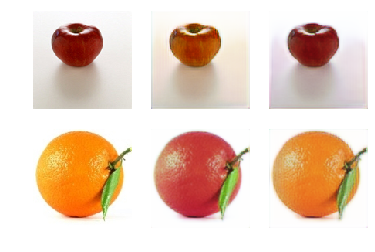

In [328]:
import matplotlib.pyplot as plt

test_dl = DataLoader(datapath='apple2orange')
batch_gen = test_dl.load_batch(1, is_testing=True)
x = next(batch_gen)

apple = x[0]
orange = x[1]

fake_orange = net.g_AB.predict(apple)
fake_apple = net.g_BA.predict(orange)

recon_apple = net.g_BA.predict(fake_orange)
recon_orange = net.g_AB.predict(fake_apple)

gen_imgs = [
    (apple[0] + 1) / 2,
    (fake_orange[0] + 1) / 2,
    (recon_apple[0] + 1) / 2,
    (orange[0] + 1) / 2,
    (fake_apple[0] + 1) / 2,
    (recon_orange[0] + 1) / 2
]

r, c = 2, 3
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
  for j in range(c):
    axs[i, j].imshow(gen_imgs[cnt])
    axs[i, j].axis('off')
    cnt += 1